# Your first neural network

In this project, you'll build your first neural network and use it to predict daily bike rental ridership. We've provided some of the code, but left the implementation of the neural network up to you (for the most part). At the very bottom of the notebook, you'll find some unit tests to check the correctness of your neural network. Be sure to run these before you submit your project.

After you've submitted this project, feel free to explore the data and the model more.



In [15]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load and prepare the data

A critical step in working with neural networks is preparing the data correctly. Variables on different scales make it difficult for the network to efficiently learn the correct weights. Below, we've written the code to load and prepare the data. You'll learn more about this soon!

In [16]:
data_path = 'Bike-Sharing-Dataset/hour.csv'

rides = pd.read_csv(data_path)

In [17]:
rides.shape

(17379, 17)

## Checking out the data

This dataset has the number of riders for **each hour of each day from January 1 2011 to December 31 2012**. The number of riders is split between **casual and registered**, summed up in the `cnt` column. You can see the first few rows of the data above.

Below is a **plot** showing the number of bike riders over the **first 10 days** in the data set. You can see the hourly rentals here. This data is pretty complicated! The **weekends have lower** over all ridership and there are **spikes** when people are biking **to and from work during the week**. Looking at the data above, we also have information about **temperature, humidity, and windspeed**, all of these likely affecting the number of riders. You'll be trying to capture all this with your model.

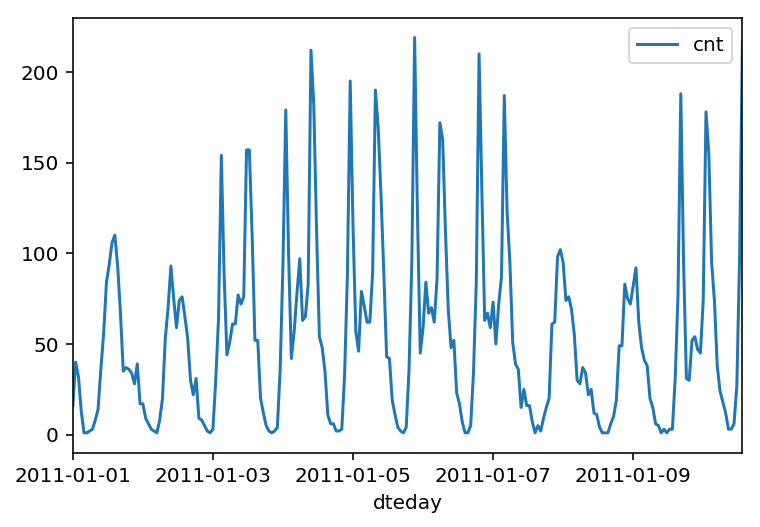

In [18]:
rides[:24*10].plot(x='dteday', y='cnt') # date vs total rents of the hour

### Dummy variables
Here we have some categorical variables like season, weather, month. To include these in our model, we'll need to make binary dummy variables. This is simple to do with Pandas thanks to `get_dummies()`.

In [19]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    
    # get dummies for each categorical variable
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    
    # all all these dummy variables to the original dataset
    rides = pd.concat([rides, dummies], axis=1)

print(rides.shape)
    # remove all the variables below from the dataset
fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)

print(data.shape)
data.head()

(17379, 68)
(17379, 59)


,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


### Scaling target variables
To make training the network easier, we'll standardize each of the continuous variables. That is, we'll shift and scale the variables such that they have zero mean and a standard deviation of 1.

The scaling factors are saved so we can go backwards when we use the network for predictions.

In [20]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']

# Store scalings (all scaled series) in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

### Splitting the data into training, testing, and validation sets

We'll save the last 21 days of the data to use as a test set after we've trained the network. We'll use this set to make predictions and compare them with the actual number of riders.

In [21]:
# Save the last 21 days as Test set
test_data = data[-21*24:]

# Save rest of data into variable data
data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]

# separate features and targets for test set
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

We'll split the data into two sets, **one for training and one for validating** as the network is being trained. It's important to split the data randomly so all cases are represented in both sets.

In [22]:
# num of examples or data point from training set
n_records = features.shape[0]

# create a random index sample about 80% of them
split = np.random.choice(features.index, 
                         size=int(n_records*0.8), 
                         replace=False)
train_features, train_targets = features.ix[split], targets.ix[split]
val_features, val_targets = features.drop(split), targets.drop(split)

In [23]:
print('total training set: {}, total validation set: {}, total test set: {}'.format(
    train_features.shape[0], val_features.shape[0], test_features.shape[0]))
print('total days:{:.2f}, training days:{:.2f}, valid days: {:.2f}, test days: {:.2f}'.format(
data.shape[0]/24, train_features.shape[0]/24, val_features.shape[0]/24, test_features.shape[0]/24))
print("it covers 2 years, train and valid set are randomized, but test set is the last 21 days of second year")

total training set: 13500, total validation set: 3375, total test set: 504
total days:703.12, training days:562.50, valid days: 140.62, test days: 21.00
it covers 2 years, train and valid set are randomized, but test set is the last 21 days of second year


In [24]:
train_features.shape[1]

56

## Time to build the network

Below you'll build your network. We've built out the structure and the backwards pass. . You'll implement the forward pass through the network. **You'll also set the hyperparameters: the learning rate, the number of hidden units, and the number of training passes**.

The network has two layers, a hidden layer and an output layer. **The hidden layer will use the sigmoid function for activations**. **The output layer has only one node** and is used for the regression, **the output of the node is the same as the input of the node. That is, the activation function is $f(x)=x$.** A function that takes the input signal and generates an output signal, but takes into account the threshold, is called an activation function. We work through each layer of our network calculating the outputs for each neuron. All of the outputs from one layer become inputs to the neurons on the next layer. This process is called *forward propagation*.

We use the weights to propagate signals forward from the input to the output layers in a neural network. We use the weights to also propagate error backwards from the output back into the network to update our weights. This is called *backpropagation*.

> **Hint:** You'll need the derivative of the output activation function ($f(x) = x$) for the backpropagation implementation. If you aren't familiar with calculus, this function is equivalent to the equation $y = x$. What is the slope of that equation? That is the derivative of $f(x)$. **derivative of f(x) = 1**

Below, you have these tasks:
1. Implement the sigmoid function to use as the activation function. Set `self.activation_function` in `__init__` to your sigmoid function.
2. Implement the forward pass in the `train` method.
3. Implement the backpropagation algorithm in the `train` method, including calculating the output error.
4. Implement the forward pass in the `run` method.
  

In [25]:
class NeuralNetwork:
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Initialize weights
        self.weights_input_to_hidden = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                                (self.hidden_nodes, self.input_nodes))
        # matrix: 10 rows, 56 columns
        
    
        self.weights_hidden_to_output = np.random.normal(0.0, self.output_nodes**-0.5, 
                                                (self.output_nodes, self.hidden_nodes))
        # matrix: 1 row, 10 columns
        
        
        self.learning_rate = learning_rate
        
        #### Set this to your implemented sigmoid function ####
        # TODO: Activation function is the sigmoid function
        
        # x is weighted sum of input and weights_input_to_hidden
        self.activation_function = lambda x: 1/(1+np.exp(-x))
    
    # it takes one data point at a time
    def train(self, inputs_list, targets_list):
        
        # Convert inputs list to 2d array
        inputs = np.array(inputs_list, ndmin=2).T 
        # inputs is a column, is a single data point
        # return (56, 1)
        
        targets = np.array(targets_list, ndmin = 2).T
        # targets is a single data point scalar
        
        #### Implement the forward pass here ####
        ### Forward pass ###
        # TODO: Hidden layer
        hidden_inputs = np.dot(self.weights_input_to_hidden, inputs)
        # signals into hidden layer
        # self.weights_input_to_hidden (10, 56), inputs (56, 1)
        # a column of 10 values (10, 1)
        
        hidden_outputs = self.activation_function(hidden_inputs)
        # signals from hidden layer
        # a column of 10 values (10, 1)
        
        
        # TODO: Output layer
        final_inputs = np.dot(self.weights_hidden_to_output, hidden_outputs)
        # signals into final output layer
        # return a scalar
        
        final_outputs = final_inputs# signals from final output layer
        # return a scalar
        
# ------ 
# I have two versions of the following 5 lines of codes. The first one is my code, 
# the second one is a corrected version of my code with help of a kind mentor on forum

# The first version is intended to mimic exactly what I learnt from 
# example code of 14.Backpropagation page. 

# I have two questions about this first version: 
# question1: why must targets - final_outputs, not the other way around?
# question2: According to course example code, if activation function of output layer is 
# sigmoid funciton, then `hidden_errors = output_errors * final_output * (1 - final_output) 
# However, the activation funciton of output layer is final inputs itself, so derivative is 1
# I used `hidden_errors = output_errors * 1`. Is there anything wrong about it?

# ------
        
# ---------------- my code tries to mimic example code of 14.Backpropagation page -----------        
        #### Implement the backward pass here ####
        ### Backward pass ###
        
        # TODO: Output error
        # given activation function of output is f(a) = a, derivative of E = -(y - \hat{y})*x_i
        # then output_error = -(y - \hat{y}); x_i = hidden_output
        output_errors = targets - final_outputs # corrected: by switch position
        # Output layer error is the difference between desired target and actual output.
        # ***Question***: Why? simple answer from reviewer: 
        # if switched, then update weights would be using -=, rather than +=
        
        # TODO: Backpropagated error
        # hidden_errors = np.dot(weights_hidden_output, output_errors) * derivative(hidden_output)
        # this project split hidden_errors = part1 * part2
        # part1 = hidden_errors_here = np.dot(weights_hidden_output, output_errors)
        # part2 = hidden_grad = derivative(hidden_output) = hidden_output*(1-hidden_output)
        hidden_errors = np.dot(self.weights_hidden_to_output.T, output_errors)


        hidden_grad = hidden_outputs * (1 - hidden_outputs) 
        # return shape as np.dot(1)(1,10) = (1, 10)
        # return (1, 10)T * (10,1) * (10,1) = (10, 1)
        
        # TODO: Update the weights
        self.weights_hidden_to_output += self.learning_rate * output_errors * hidden_outputs.T
        # update hidden-to-output weights with gradient descent step
        # (1, 10) += scalar * scalar * (10,1)T
        
        self.weights_input_to_hidden += self.learning_rate * hidden_errors * hidden_grad * inputs.T
        # update input-to-hidden weights with gradient descent step
        # (10, 56) = scalar * (10, 1) * (56, 1)T = (10, 56)
        

# ------------------------ the second version ------------------
# all the elements are the same, the difference is that `hidden_grad` in previous version is 
# splitted into `hidden_errors` and `hidden_grad` here. but I prefer the logic of previous version
# because it is following the logic of 11.Gradient descent and 14.Backpropagation

# What do you think? Does my first version make sense? or second version is actually the only 
# correct way of expressing backpropagation here? Thanks

#         output_errors =  targets - final_outputs

#         hidden_errors = np.dot(self.weights_hidden_to_output.T, output_errors)

#         hidden_grad = hidden_outputs * (1 - hidden_outputs) 
        
#         self.weights_hidden_to_output += self.learning_rate * output_errors * hidden_outputs.T

#         self.weights_input_to_hidden += self.learning_rate * hidden_grad * hidden_errors * inputs.T

# this is exactly the same code as my first version, just slightly in different order!!!

# --------------------------------
    
    def run(self, inputs_list):
        # Run a forward pass through the network
        inputs = np.array(inputs_list, ndmin=2).T
        # return (56, 1)
        
        #### Implement the forward pass here ####
        # TODO: Hidden layer
        hidden_inputs = np.dot(self.weights_input_to_hidden, inputs) 
        # signals into hidden layer
        # input (56, 1), weights_input_to_hidden (10, 56)
        # return (10, 1)
        
        hidden_outputs = self.activation_function(hidden_inputs)
        # signals from hidden layer
        # return (10,1)
        
        # TODO: Output layer
        final_inputs = np.dot(self.weights_hidden_to_output, hidden_outputs)
        # signals into final output layer
        # (10, 1) dot (1, 10)
        
        final_outputs = final_inputs# signals from final output layer
        
        return final_outputs

In [26]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

## Training the network

Here you'll set the hyperparameters for the network. You'll also be using a method know as Stochastic Gradient Descent (SGD) to train the network. The idea is that for each training pass, you grab a random sample of the data instead of using the whole data set. You use many more training passes than with normal gradient descent, but each pass is much faster. This ends up training the network faster. You'll learn more about SGD later.

### Choose the number of epochs
This is the number of times the dataset will pass through the network, each time updating the weights. As the number of epochs increases, the network becomes better and better at predicting the targets in the training set. However, it can become too specific to the training set and will fail to generalize to the validation set. This is called overfitting. **You'll need to choose enough epochs to train the network well but not too many or you'll be overfitting**.

### Choose the learning rate
This scales the size of weight updates. If this is too big, the weights tend to explode and the network fails to fit the data. **A good choice to start at is 0.1. If the network has problems fitting the data, try reducing the learning rate**. Note that the lower the learning rate, the smaller the steps are in the weight updates and the longer it takes for the neural network to converge.

### Choose the number of hidden nodes
The more hidden nodes you have, the more accurate predictions the model will make. Try a few different numbers and see how it affects the performance. You can look at the losses dictionary for a metric of the network performance. **If the number of hidden units is too low, then the model won't have enough space to learn and if it is too high there are too many options for the direction that the learning can take**. The trick here is to find the right balance in number of hidden units you choose.

In [27]:
def overfit_test(epochs = 1000, hidden_nodes = 10, learning_rate = 0.01):

    ### Set the hyperparameters here ###
    epochs 
    learning_rate 
    hidden_nodes 
    output_nodes = 1

    # number of features or input nodes
    N_i = train_features.shape[1]
    network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

    losses = {'train':[], 'validation':[]}

    for e in range(epochs):
        # Go through a random batch of 128 records from the training data set
        batch = np.random.choice(train_features.index, size=128) # 128

        # for each batch 128 data points, iterate through each data point
        for record, target in zip(train_features.ix[batch].values, 
                                  train_targets.ix[batch]['cnt']):

            # train network with each data point 
            network.train(record, target)

        # every 100 or 10 epochs, store errors for the current value
        if e%(epochs/10) == 0:

            # calc loss func: mean squared error for training set
            # Calculate losses for the training and test sets
            train_loss = MSE(network.run(train_features), train_targets['cnt'].values)

            # calc error: mean squared error for validation set
            val_loss = MSE(network.run(val_features), val_targets['cnt'].values)

            # store two errors inside dictionary losses
            losses['train'].append(train_loss)
            losses['validation'].append(val_loss)

            # Print out the losses as the network is training
            print('Training loss: {:.4f}'.format(train_loss))
            print('Validation loss: {:.4f}'.format(val_loss))


    # plot error for training set and validation set along the way
    plt.plot(losses['train'], label='Training loss')
    plt.plot(losses['validation'], label='Validation loss')
    plt.legend()

### effect of num of epochs, keep other hyperparameters fixed

- given hidden_nodes = 10, learning_rate = 0.01
- Generally, more epoches, better learnt model
- if epoches are small like 100, then neural network could not update its weights enough to learn enough. Therefore, the error on both training and validation sets are high
- But since the network has remembered 128*100 data point inside training set, when trainning error is significantly smaller than validation error, then it is probably due to memory rather than predictive power.
- As epoches increase, both training error and validation error decrease, and gap between training and validation errors are getting smaller in general (overfitting is reducing)
- **epochs can be as large as you have enough time and computation power to spend on**

Training loss: 1.0207
Validation loss: 0.9833
Training loss: 0.5298
Validation loss: 0.5306
Training loss: 0.4227
Validation loss: 0.4364
Training loss: 0.3651
Validation loss: 0.3821
Training loss: 0.3391
Validation loss: 0.3569
Training loss: 0.3276
Validation loss: 0.3461
Training loss: 0.3124
Validation loss: 0.3338
Training loss: 0.3154
Validation loss: 0.3336
Training loss: 0.3079
Validation loss: 0.3240
Training loss: 0.3043
Validation loss: 0.3248


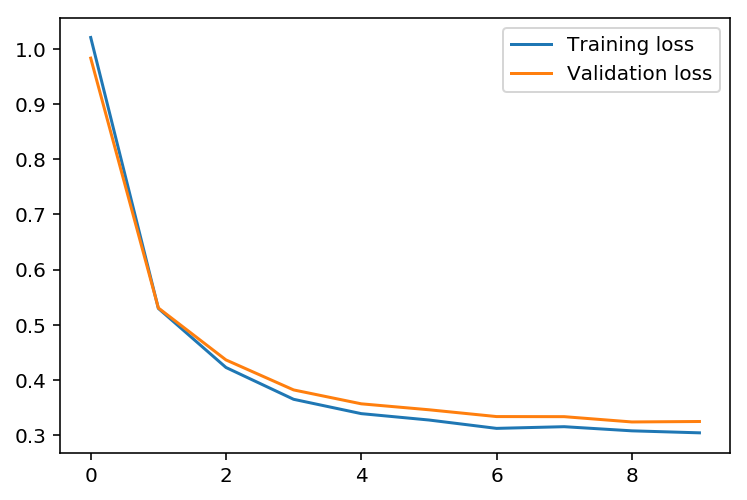

In [28]:
overfit_test(100) # 0.3113, 0.3308, there is significant gap between trainning and valid errors

Training loss: 1.0497
Validation loss: 1.0661
Training loss: 0.3434
Validation loss: 0.3718
Training loss: 0.2984
Validation loss: 0.3183
Training loss: 0.2813
Validation loss: 0.2982
Training loss: 0.2793
Validation loss: 0.2994
Training loss: 0.2636
Validation loss: 0.2831
Training loss: 0.2563
Validation loss: 0.2782
Training loss: 0.2535
Validation loss: 0.2752
Training loss: 0.2438
Validation loss: 0.2653
Training loss: 0.2246
Validation loss: 0.2465


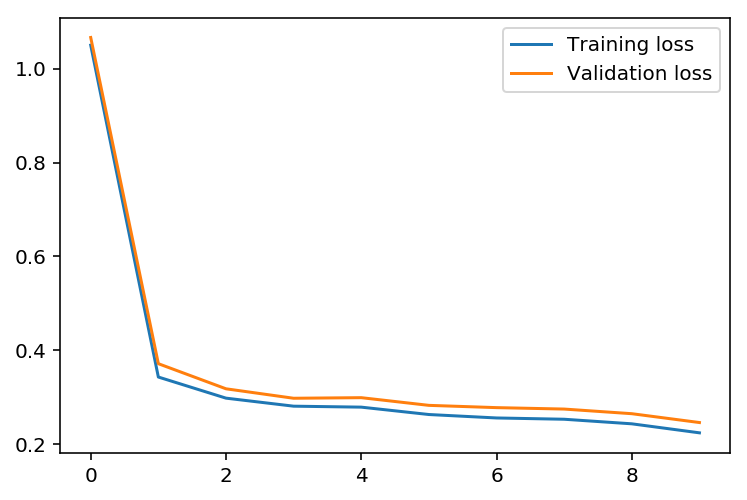

In [29]:
overfit_test(500) # 0.2426, 0.2545

Training loss: 1.2001
Validation loss: 1.1844
Training loss: 0.3180
Validation loss: 0.3406
Training loss: 0.2836
Validation loss: 0.3007
Training loss: 0.2749
Validation loss: 0.2995
Training loss: 0.2613
Validation loss: 0.2798
Training loss: 0.2470
Validation loss: 0.2672
Training loss: 0.2302
Validation loss: 0.2541
Training loss: 0.2074
Validation loss: 0.2276
Training loss: 0.1880
Validation loss: 0.2100
Training loss: 0.1653
Validation loss: 0.1805


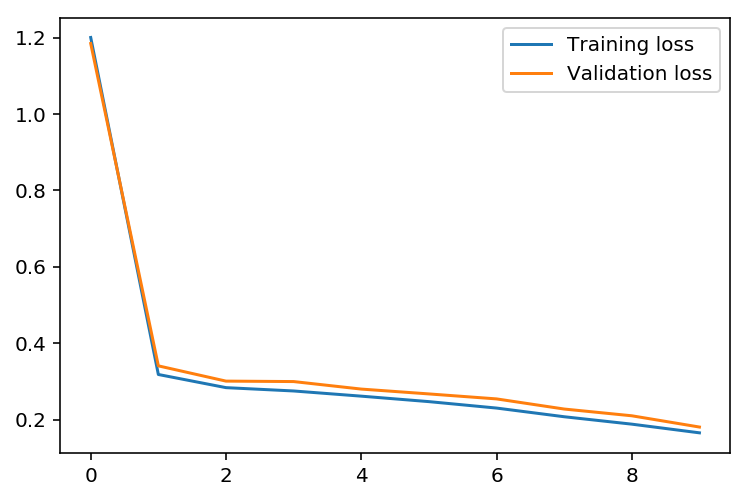

In [30]:
overfit_test(1000) # Training loss: 0.1189  Validation loss: 0.1235

### Effect of Learning_rate, keep other parameters fixed

Learning_rate controls how fast or how big step does each weight update take. Learning rate should NOT be too large or small. 
- given epochs = 10000, hidden_nodes = 10
- If learning_rate is too large (here 0.5), it learns slowly as it overshoot and weights jump back and forward between the optimal
- if learning_rate is too small, here 0.001, learning is very slow with error about 0.11 after 10000 iterations
- learning_rate 0.1 and 0.01 are about the same, **0.01 is slightly better**

Training loss: 0.9367
Validation loss: 0.9599
Training loss: 0.0812
Validation loss: 0.0820
Training loss: 0.0780
Validation loss: 0.0811
Training loss: 0.0934
Validation loss: 0.0950
Training loss: 0.0858
Validation loss: 0.0898
Training loss: 0.0849
Validation loss: 0.0869
Training loss: 0.1187
Validation loss: 0.1324
Training loss: 0.0741
Validation loss: 0.0772
Training loss: 0.0754
Validation loss: 0.0796
Training loss: 0.0898
Validation loss: 0.0924


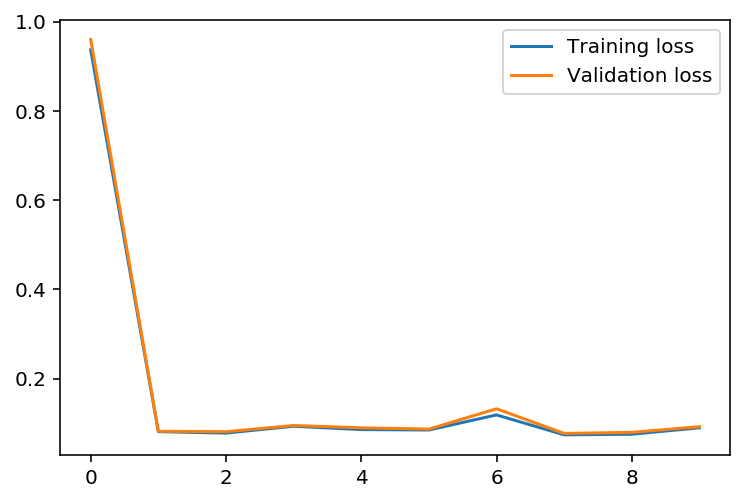

In [31]:
overfit_test(learning_rate=0.5, epochs=10000)# Training loss: 0.0865 Validation loss: 0.0882

Training loss: 0.8364
Validation loss: 0.8647
Training loss: 0.0655
Validation loss: 0.0653
Training loss: 0.0614
Validation loss: 0.0622
Training loss: 0.0563
Validation loss: 0.0580
Training loss: 0.0573
Validation loss: 0.0587
Training loss: 0.0552
Validation loss: 0.0560
Training loss: 0.0541
Validation loss: 0.0554
Training loss: 0.0554
Validation loss: 0.0579
Training loss: 0.0558
Validation loss: 0.0562
Training loss: 0.0550
Validation loss: 0.0565


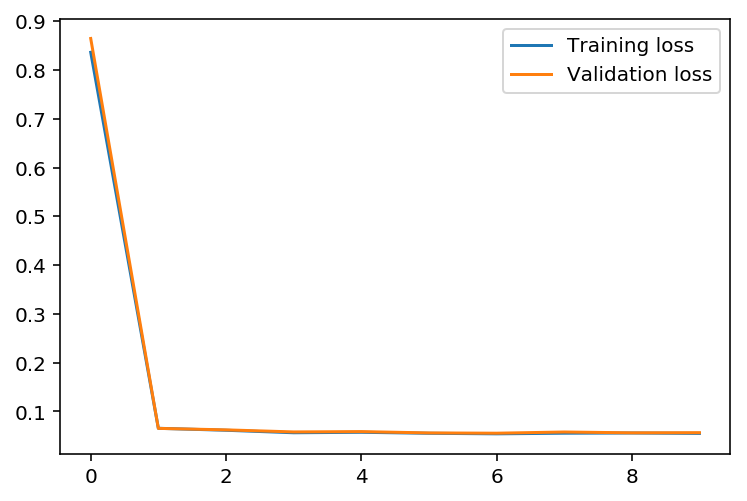

In [32]:
overfit_test(learning_rate=0.1, epochs=10000) 
# Training loss: 0.0688 Validation loss: 0.0702 Training loss: 0.0578  Validation loss: 0.0577

Training loss: 1.0731
Validation loss: 1.1084
Training loss: 0.0996
Validation loss: 0.1012
Training loss: 0.0695
Validation loss: 0.0693
Training loss: 0.0630
Validation loss: 0.0601
Training loss: 0.0624
Validation loss: 0.0583
Training loss: 0.0603
Validation loss: 0.0588
Training loss: 0.0598
Validation loss: 0.0571
Training loss: 0.0599
Validation loss: 0.0595
Training loss: 0.0572
Validation loss: 0.0547
Training loss: 0.0592
Validation loss: 0.0583


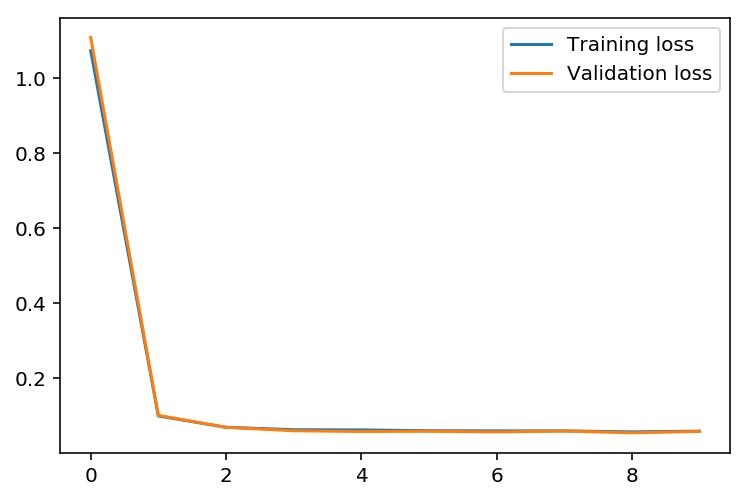

In [33]:
overfit_test(learning_rate=0.01, epochs=10000) 
# Training loss: 0.0597 Validation loss: 0.0607 Training loss: 0.0545 Validation loss: 0.0559

Training loss: 1.1848
Validation loss: 1.2064
Training loss: 0.3096
Validation loss: 0.3284
Training loss: 0.2793
Validation loss: 0.2944
Training loss: 0.2629
Validation loss: 0.2740
Training loss: 0.2396
Validation loss: 0.2489
Training loss: 0.2044
Validation loss: 0.2127
Training loss: 0.1686
Validation loss: 0.1770
Training loss: 0.1428
Validation loss: 0.1488
Training loss: 0.1237
Validation loss: 0.1298
Training loss: 0.1118
Validation loss: 0.1164


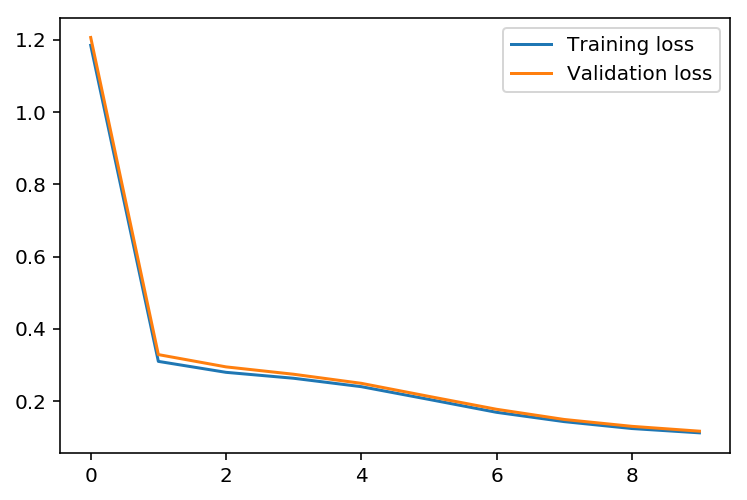

In [34]:
overfit_test(learning_rate=0.001, epochs=10000) 
# Training loss: 0.1188 Validation loss: 0.1267 Training loss: 0.1063 Validation loss: 0.1131

### Effect of hidden_nodes, keep other parameters fixed

More hidden_nodes help learn more patterns and increase predictive power.
- given epochs = 10000, learning_rate = 0.01
- if node are few, like 5 and 10, then it learns slowly or not learn very well
- if nodes are too many, like 50 and 100 training error and validation error are not significantly smaller than 20 nodes, but their value difference between training and validation error is bigger than that of 20-nodes model
- trying nodes with 5, 10, 20, 50, 100, **20 is best choice**

Training loss: 1.3182
Validation loss: 1.3068
Training loss: 0.1150
Validation loss: 0.1191
Training loss: 0.0953
Validation loss: 0.0968
Training loss: 0.0895
Validation loss: 0.0914
Training loss: 0.0820
Validation loss: 0.0838
Training loss: 0.0775
Validation loss: 0.0775
Training loss: 0.0738
Validation loss: 0.0742
Training loss: 0.0716
Validation loss: 0.0699
Training loss: 0.0718
Validation loss: 0.0703
Training loss: 0.0734
Validation loss: 0.0734


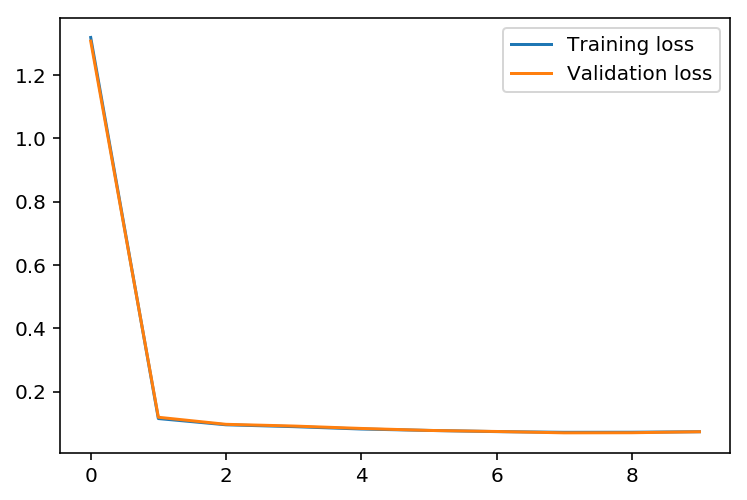

In [35]:
overfit_test(hidden_nodes=5, epochs = 10000) 
# Training loss: 0.0679 Validation loss: 0.0658 Training loss: 0.0702 Validation loss: 0.0696

Training loss: 1.0670
Validation loss: 1.1044
Training loss: 0.1070
Validation loss: 0.1100
Training loss: 0.0877
Validation loss: 0.0891
Training loss: 0.0814
Validation loss: 0.0834
Training loss: 0.0754
Validation loss: 0.0770
Training loss: 0.0687
Validation loss: 0.0698
Training loss: 0.0647
Validation loss: 0.0648
Training loss: 0.0645
Validation loss: 0.0640
Training loss: 0.0629
Validation loss: 0.0634
Training loss: 0.0645
Validation loss: 0.0642


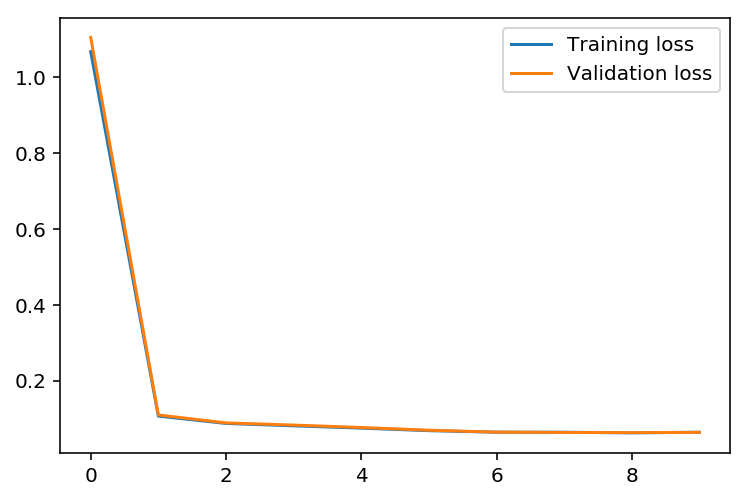

In [36]:
overfit_test(hidden_nodes=10, epochs = 10000) 
# Training loss: 0.0574 Validation loss: 0.0597 Training loss: 0.0597 Validation loss: 0.0624

Training loss: 0.8929
Validation loss: 0.8942
Training loss: 0.1052
Validation loss: 0.1077
Training loss: 0.0741
Validation loss: 0.0749
Training loss: 0.0698
Validation loss: 0.0718
Training loss: 0.0658
Validation loss: 0.0676
Training loss: 0.0595
Validation loss: 0.0608
Training loss: 0.0668
Validation loss: 0.0685
Training loss: 0.0562
Validation loss: 0.0567
Training loss: 0.0550
Validation loss: 0.0552
Training loss: 0.0556
Validation loss: 0.0555


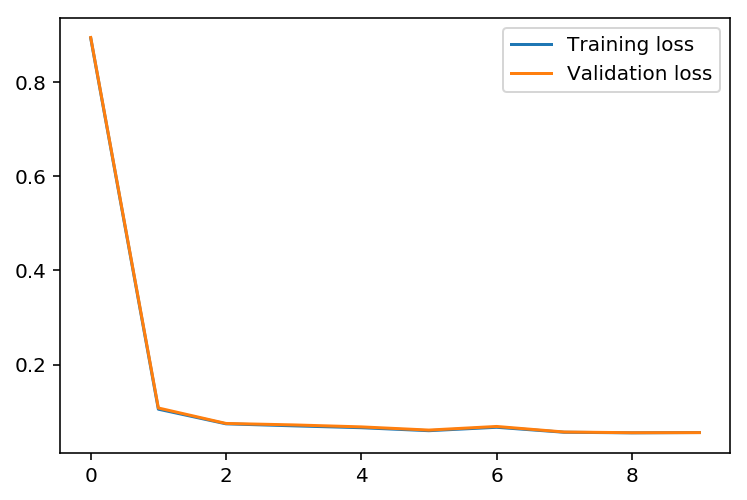

In [37]:
overfit_test(hidden_nodes=20, epochs = 10000) 
# Training loss: 0.0532 Validation loss: 0.0548 Training loss: 0.0537 Validation loss: 0.0548

Training loss: 0.8744
Validation loss: 0.8714
Training loss: 0.1196
Validation loss: 0.1256
Training loss: 0.0741
Validation loss: 0.0735
Training loss: 0.0700
Validation loss: 0.0700
Training loss: 0.0571
Validation loss: 0.0573
Training loss: 0.0562
Validation loss: 0.0575
Training loss: 0.0521
Validation loss: 0.0543
Training loss: 0.0538
Validation loss: 0.0552
Training loss: 0.0527
Validation loss: 0.0550
Training loss: 0.0535
Validation loss: 0.0561


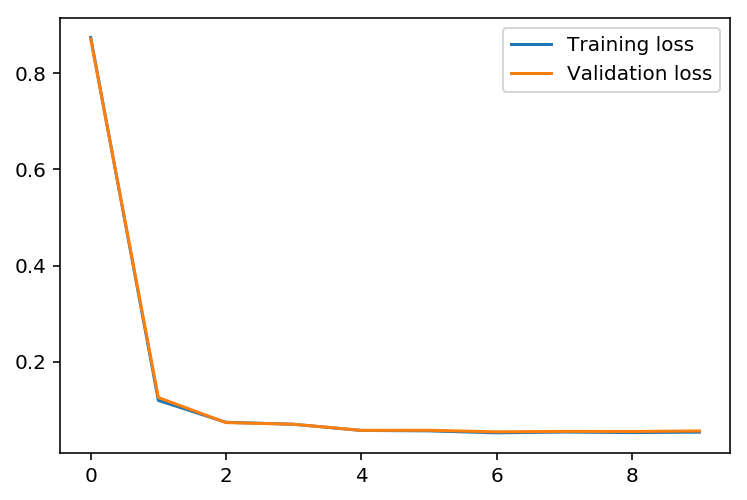

In [38]:
overfit_test(hidden_nodes=50, epochs=10000) 
# Training loss: 0.0543 Validation loss: 0.0577 Training loss: 0.0515 Validation loss: 0.0581

Training loss: 1.5562
Validation loss: 1.5450
Training loss: 0.1184
Validation loss: 0.1260
Training loss: 0.0732
Validation loss: 0.0742
Training loss: 0.0656
Validation loss: 0.0694
Training loss: 0.0593
Validation loss: 0.0602
Training loss: 0.0556
Validation loss: 0.0579
Training loss: 0.0585
Validation loss: 0.0610
Training loss: 0.0555
Validation loss: 0.0571
Training loss: 0.0540
Validation loss: 0.0547
Training loss: 0.0531
Validation loss: 0.0558


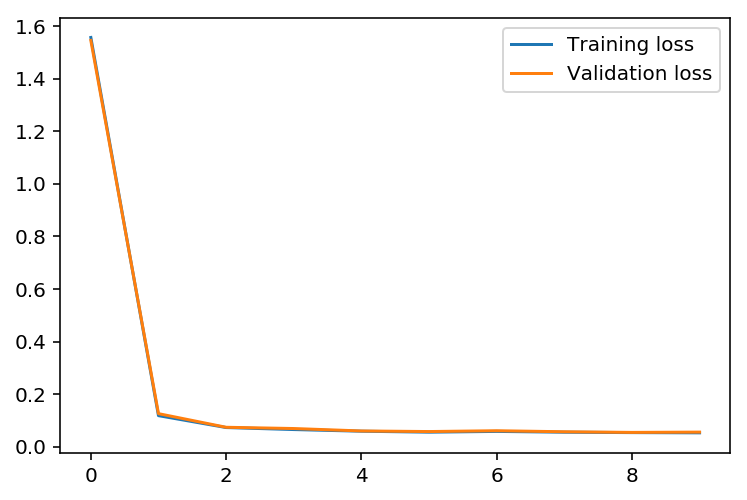

In [39]:
overfit_test(hidden_nodes=100, epochs=10000) 
# Training loss: 0.0547 Validation loss: 0.0580 Training loss: 0.0508 Validation loss: 0.0554

## Check out your predictions

Here, use the test data to check that network is accurately making predictions. If your predictions don't match the data, try adjusting the hyperparameters and check to make sure the forward passes in the network are correct.

### Try play parameters

Training loss: 1.0630
Validation loss: 1.0795
Training loss: 0.2223
Validation loss: 0.2424
Training loss: 0.0778
Validation loss: 0.0814
Training loss: 0.0641
Validation loss: 0.0657
Training loss: 0.0611
Validation loss: 0.0619
Training loss: 0.0597
Validation loss: 0.0603
Training loss: 0.0560
Validation loss: 0.0572
Training loss: 0.0568
Validation loss: 0.0585
Training loss: 0.0569
Validation loss: 0.0572
Training loss: 0.0536
Validation loss: 0.0557


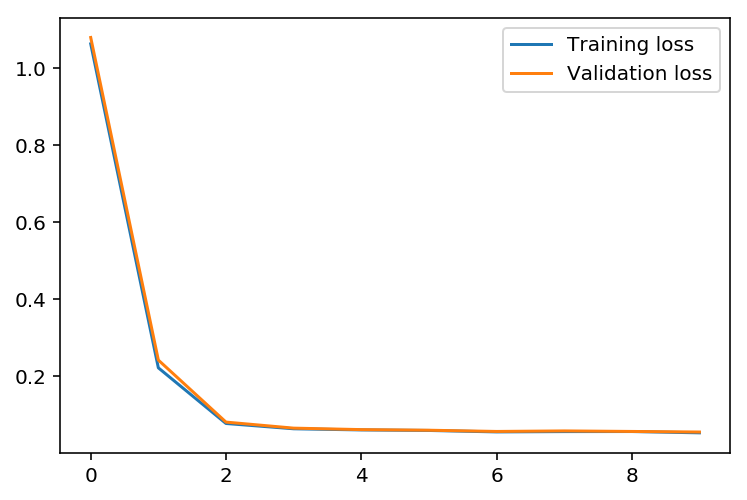

In [40]:
# Train a neural network with 20 hidden_nodes, at learning_rate = 0.01, over 10000 times
overfit_test(hidden_nodes=20, learning_rate=0.01, epochs=10000) 
# Training loss: 0.0530 Validation loss: 0.0552 Training loss: 0.0523 Validation loss: 0.0545

In [41]:
# overfit_test(hidden_nodes=20, learning_rate=0.01, epochs=50000) 
# 0.0526, 0.0580 not a huge differece

In [42]:
def accuracy_test(epochs = 1000, hidden_nodes = 10, learning_rate = 0.01):

    ### Set the hyperparameters here ###
    epochs
    learning_rate 
    hidden_nodes
    output_nodes = 1

    # number of features or input nodes
    N_i = train_features.shape[1]
    network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

    losses = {'train':[], 'validation':[], 'test':[]}

    for e in range(epochs):
        # Go through a random batch of 128 records from the training data set
        batch = np.random.choice(train_features.index, size=128) # 128

        # for each batch 128 data points, iterate through each data point
        for record, target in zip(train_features.ix[batch].values, 
                                  train_targets.ix[batch]['cnt']):

            # train network with each data point 
            network.train(record, target)

        # every 100 or 10 epochs, store errors for the current value
        if e%(epochs/10) == 0:

            # calc loss func: mean squared error for training set
            # Calculate losses for the training and test sets
            train_loss = MSE(network.run(train_features), train_targets['cnt'].values)

            # calc error: mean squared error for validation set
            val_loss = MSE(network.run(val_features), val_targets['cnt'].values)

            test_loss = MSE(network.run(test_features), test_targets['cnt'].values)

            # store two errors inside dictionary losses
            losses['train'].append(train_loss)
            losses['validation'].append(val_loss)
            losses['test'].append(test_loss)
            
            # Print out the losses as the network is training
            print('Training loss: {:.4f}, Validation loss: {:.4f}, Test loss: {:.4f}'.format(train_loss, val_loss, test_loss))
#             print('Validation loss: {:.4f}'.format(val_loss))


    # plot error for training set and validation set along the way
    plt.plot(losses['train'], label='Training loss')
    plt.plot(losses['validation'], label='Validation loss')
    plt.plot(losses['test'], label='Test loss')
    plt.legend()

    test_loss = MSE(network.run(test_features), test_targets['cnt'].values)

    fig, ax = plt.subplots(figsize=(8,4))

    # bring predictions and target labels back to original scale
    mean, std = scaled_features['cnt']
    predictions = network.run(test_features)*std + mean

    # plot predictions and true labels
    ax.plot(predictions[0], label='Prediction')
    ax.plot((test_targets['cnt']*std + mean).values, label='Data')

    # add xlim and legend
    ax.set_xlim(right=len(predictions))
    ax.legend()

    # adding date onto plot
    dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
    dates = dates.apply(lambda d: d.strftime('%b %d'))
    ax.set_xticks(np.arange(len(dates))[12::24])
    _ = ax.set_xticklabels(dates[12::24], rotation=45)

Training loss: 0.9009, Validation loss: 0.9203, Test loss: 0.7976
Training loss: 0.1513, Validation loss: 0.1630, Test loss: 0.2190
Training loss: 0.0760, Validation loss: 0.0751, Test loss: 0.1471
Training loss: 0.0657, Validation loss: 0.0649, Test loss: 0.1545
Training loss: 0.0613, Validation loss: 0.0612, Test loss: 0.1220
Training loss: 0.0581, Validation loss: 0.0583, Test loss: 0.1321
Training loss: 0.0573, Validation loss: 0.0572, Test loss: 0.1136
Training loss: 0.0557, Validation loss: 0.0570, Test loss: 0.1355
Training loss: 0.0537, Validation loss: 0.0545, Test loss: 0.1521
Training loss: 0.0568, Validation loss: 0.0590, Test loss: 0.1337


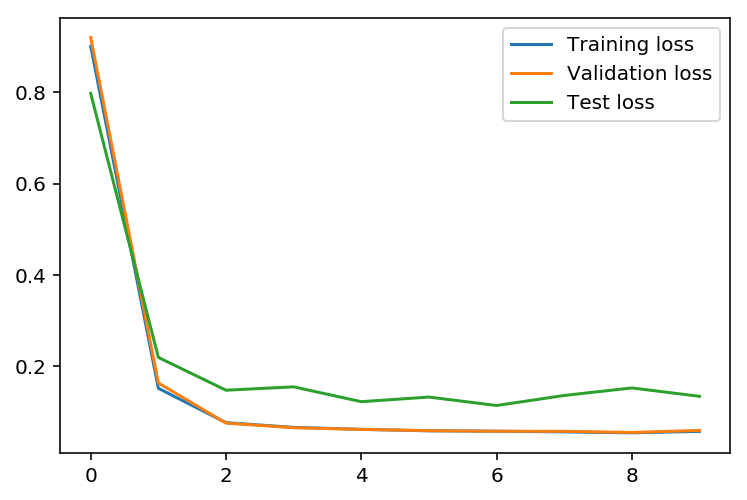

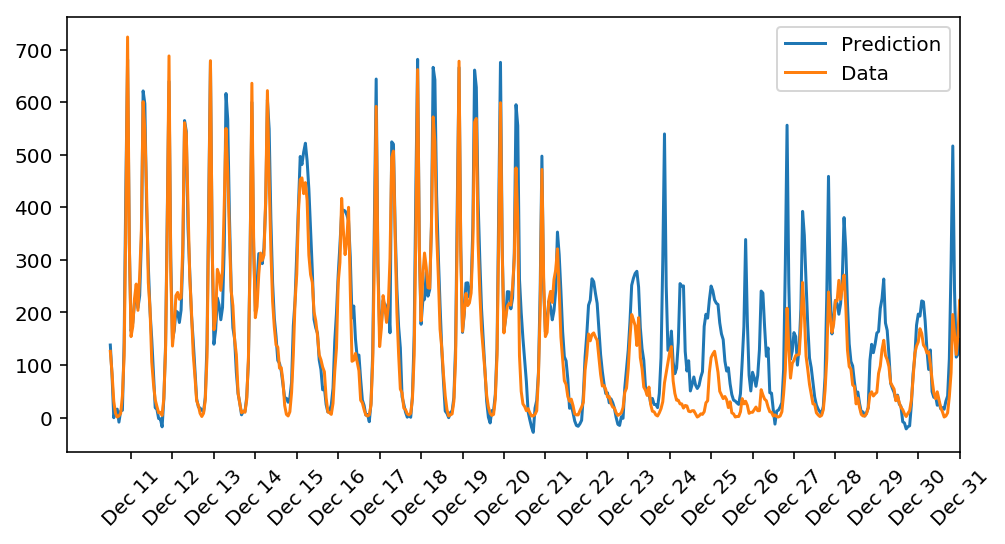

In [43]:
accuracy_test(hidden_nodes=20, learning_rate=0.01, epochs=10000) 
# Training loss: 0.0580 Validation loss: 0.0618 Training loss: 0.0723 Validation loss: 0.0756

In [44]:
# accuracy_test(hidden_nodes=20, learning_rate=0.01, epochs=50000) 
# Training loss: 0.0490 Validation loss: 0.0560 Training loss: 0.0510 Validation loss: 0.0572 

Training loss: 0.8299, Validation loss: 0.8537, Test loss: 0.7350
Training loss: 0.0772, Validation loss: 0.0802, Test loss: 0.1129
Training loss: 0.0501, Validation loss: 0.0520, Test loss: 0.1791
Training loss: 0.0480, Validation loss: 0.0506, Test loss: 0.1987
Training loss: 0.0481, Validation loss: 0.0506, Test loss: 0.2053
Training loss: 0.0472, Validation loss: 0.0509, Test loss: 0.1924
Training loss: 0.0441, Validation loss: 0.0475, Test loss: 0.1983
Training loss: 0.0473, Validation loss: 0.0528, Test loss: 0.1636
Training loss: 0.0457, Validation loss: 0.0503, Test loss: 0.1880
Training loss: 0.0502, Validation loss: 0.0546, Test loss: 0.2046


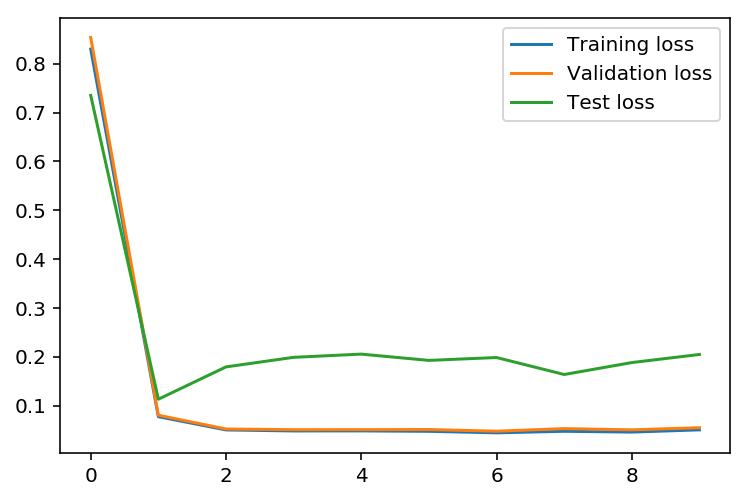

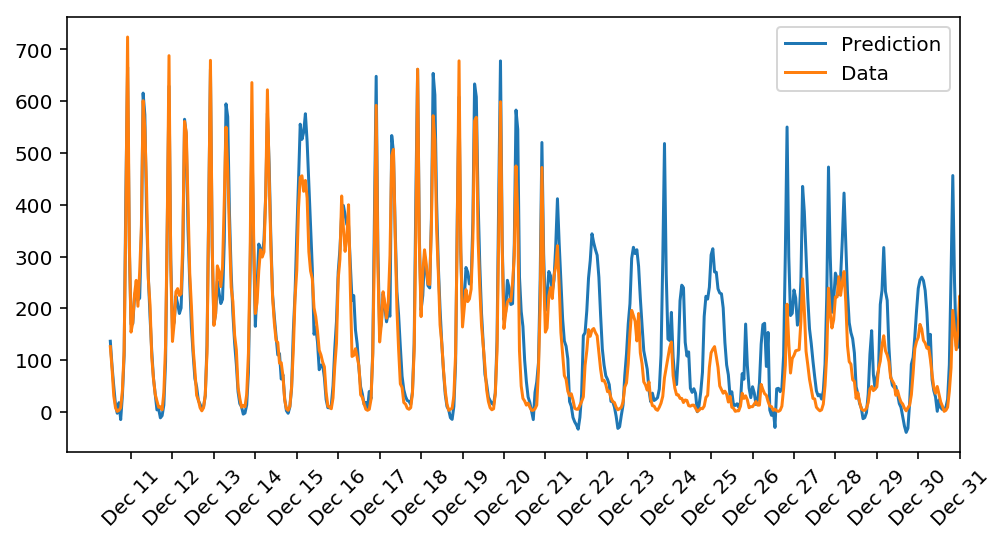

In [45]:
### Set the hyperparameters here ###
epochs = 50000
learning_rate = 0.01
hidden_nodes = 20
output_nodes = 1

# number of features or input nodes
N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[], 'test':[]}

for e in range(epochs):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128) # 128

    # for each batch 128 data points, iterate through each data point
    for record, target in zip(train_features.ix[batch].values, 
                              train_targets.ix[batch]['cnt']):

        # train network with each data point 
        network.train(record, target)

    # every 100 or 10 epochs, store errors for the current value
    if e%(epochs/10) == 0:

        # calc loss func: mean squared error for training set
        # Calculate losses for the training and test sets
        train_loss = MSE(network.run(train_features), train_targets['cnt'].values)

        # calc error: mean squared error for validation set
        val_loss = MSE(network.run(val_features), val_targets['cnt'].values)

        test_loss = MSE(network.run(test_features), test_targets['cnt'].values)

        # store two errors inside dictionary losses
        losses['train'].append(train_loss)
        losses['validation'].append(val_loss)
        losses['test'].append(test_loss)

        # Print out the losses as the network is training
        print('Training loss: {:.4f}, Validation loss: {:.4f}, Test loss: {:.4f}'.format(train_loss, val_loss, test_loss))
#             print('Validation loss: {:.4f}'.format(val_loss))


# plot error for training set and validation set along the way
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.plot(losses['test'], label='Test loss')
plt.legend()

test_loss = MSE(network.run(test_features), test_targets['cnt'].values)

fig, ax = plt.subplots(figsize=(8,4))

# bring predictions and target labels back to original scale
mean, std = scaled_features['cnt']
predictions = network.run(test_features)*std + mean

# plot predictions and true labels
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')

# add xlim and legend
ax.set_xlim(right=len(predictions))
ax.legend()

# adding date onto plot
dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

## Thinking about your results
 
Answer these questions about your results. How well does the model predict the data? Where does it fail? Why does it fail where it does?

> **Note:** You can edit the text in this cell by double clicking on it. When you want to render the text, press control + enter

#### Your answer below

**How well does the model predict the data?**
- After 50000 iterations, I got Squared Mean Errors for three datasets, which indicate performance of this model. 
- Training loss: 0.0451, Validation loss: 0.0517, Test loss: 0.1312
- Validation loss is quite close with training loss, the difference between them is about 0.006, indicating that the model has learnt the training set well and data patterns covered by training set are similar to data patterns within validation set
- Both validation loss and training loss are very low around 0.05, whereas test loss is more than doubled. This indicates that there some data patterns within test set didn't captured by our model. This is why the model perform badly in test set.


**Where does it fail**
- predictions are poor for data points starting from Dec 22 to Dec 31
- the hours most errors occured over the 21 days of test set is shown in the graph below on Cell 106: are go-to-work and off-work hours
- Why? because this model captured the pattern of go-to-work and off-work-pattern from training set, but didn't discover pattern of Christmas season, at least not the later half of the last 21 days of the year. 
- Therefore, the model predict the go-to-work and off-work peaks for the last 11 days as if Christmas does not exist. 

**Why does it fail where it does**
- data points for training are not used as time series for the following reasons: 
    - 'instant', 'dteday' columns which can define time are dropped
    - training and validation sets are randomized, withouth the order of timing
- Christmas effect on rides is very different from the rest of the year, has its own particular pattern. The pattern of Christimas effect may be best captured by date as a feature which is not availabe in training_features. 
- Therefore, model trained by dataset without date as a feature won't be able to discover pattern of Christmas effect. 
- One more reason is that the dataset only contains 2 years, and only a single Christmas season is avaliable in training set. It is hard to discover pattern using one exmaple. 
    

In [46]:
import pandas as pd
# len(network.run(test_features)[0])
temp = pd.DataFrame({'cnt':test_data.cnt, 'preds':network.run(test_features)[0]})
temp.head(2)

,cnt,preds
16875,-0.349876,-0.292476
16876,-0.581424,-0.556985


In [47]:
# print(preds.shape)
# test_data.shape
data_preds = test_data.copy()
data_preds = pd.concat([data_preds, temp.preds], axis=1)

In [48]:
# only 1 day holiday during the last 21 days, so holiday feature cannot be used 
# to mark Christmas for the model
data_preds.holiday.sum()

23

In [49]:
data_preds['error'] = (data_preds.preds - data_preds.cnt)**2

In [50]:
data_preds['hr_order'] = rides[-21*24:].hr
data_preds.head(2)

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,preds,error,hr_order
16875,1,0,0.015647,0.999178,0.276298,-0.500481,-0.256260,-0.349876,0,0,...,0,1,0,0,0,0,0,-0.292476,0.003295,22
16876,1,0,-0.192085,1.310171,0.519881,-0.561326,-0.513929,-0.581424,0,0,...,0,1,0,0,0,0,0,-0.556985,0.000597,23


,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,preds,error,hr_order
16875,1,0,0.015647,0.999178,0.276298,-0.500481,-0.256260,-0.349876,0,0,...,0,1,0,0,0,0,0,-0.292476,0.003295,22
16876,1,0,-0.192085,1.310171,0.519881,-0.561326,-0.513929,-0.581424,0,0,...,0,1,0,0,0,0,0,-0.556985,0.000597,23


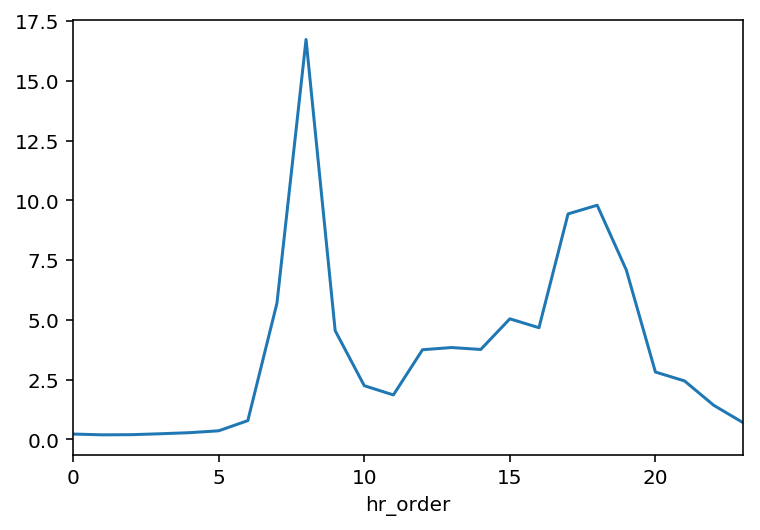

In [51]:
data_preds.groupby(by = ['hr_order']).error.sum().plot()
data_preds.head(2)

In [52]:
# test_features.shape
test_features[11*24:].shape

(240, 56)

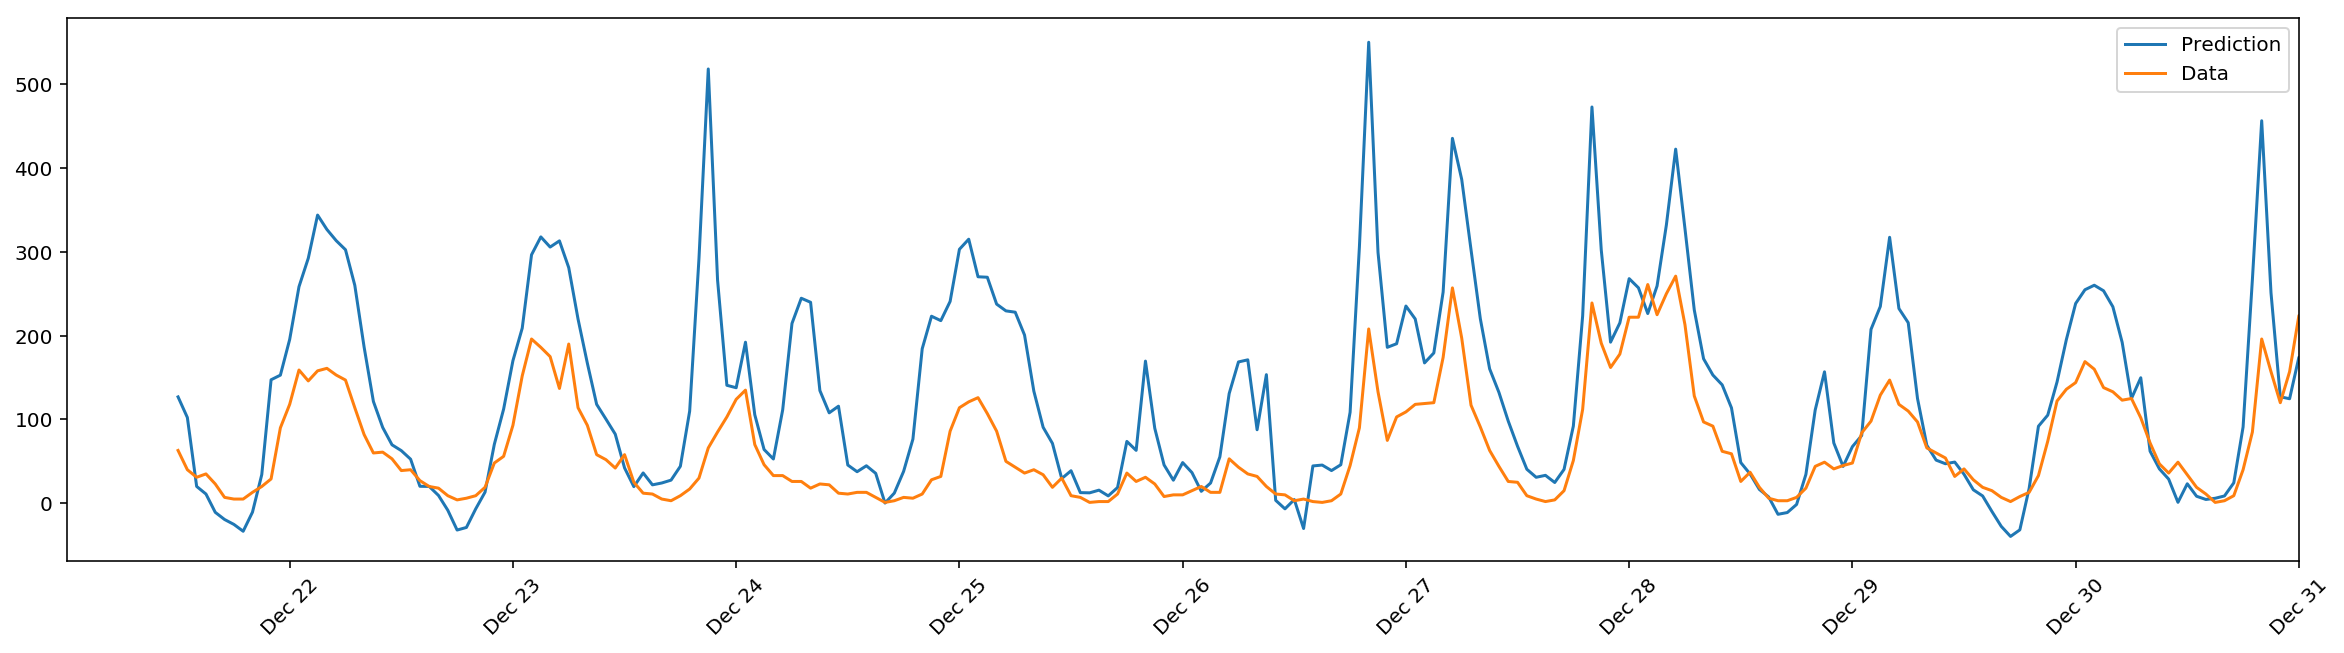

In [53]:
fig, ax = plt.subplots(figsize=(20,5))

# bring predictions and target labels back to original scale
mean, std = scaled_features['cnt']
predictions = network.run(test_features[11*24:])*std + mean

# plot predictions and true labels
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets[11*24:]['cnt']*std + mean).values, label='Data')

# add xlim and legend
ax.set_xlim(right=len(predictions))
ax.legend()

# adding date onto plot
dates = pd.to_datetime(rides.ix[test_data[11*24:].index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

## Unit tests

Run these unit tests to check the correctness of your network implementation. These tests must all be successful to pass the project.

In [54]:
import unittest

np.random.seed(42)
inputs = [0.5, -0.2, 0.1]
targets = [0.4]

class TestMethods(unittest.TestCase):
    
    ##########
    # Unit tests for data loading
    ##########
    
    def test_data_path(self):
        # Test that file path to dataset has been unaltered
        self.assertTrue(data_path == 'Bike-Sharing-Dataset/hour.csv')
        
    def test_data_loaded(self):
        # Test that data frame loaded
        self.assertTrue(isinstance(rides, pd.DataFrame))
    
    ##########
    # Unit tests for network functionality
    ##########

    def test_activation(self):
        network = NeuralNetwork(3, 2, 1, 0.5)
        # Test that the activation function is a sigmoid
        self.assertTrue(np.all(network.activation_function(0.5) == 1/(1+np.exp(-0.5))))

    def test_train(self):
        # Test that weights are updated correctly on training
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.train(inputs, targets)
        self.assertTrue(np.allclose(network.weights_hidden_to_output, 
                                    [ 0.22931895, -1.28754157]))
        self.assertTrue(np.allclose(network.weights_input_to_hidden,
                                    [[-0.7128223, 0.22086344, -0.64139849],
                                     [-1.06444693, 1.06268915, -0.17280743]]))

    def test_run(self):
        # Test correctness of run method
        network = NeuralNetwork(3, 2, 1, 0.5)
        self.assertTrue(np.allclose(network.run(inputs), -0.97900982))

suite = unittest.TestLoader().loadTestsFromModule(TestMethods())
unittest.TextTestRunner().run(suite)

.....
----------------------------------------------------------------------
Ran 5 tests in 0.006s

OK


<unittest.runner.TextTestResult run=5 errors=0 failures=0>

### Code Functionality

**All code works appropriately**: 
- criteria: All the code in the notebook runs in Python 3 without failing.
- self-assessment: running without error, but there are warnings.

**Sigmoid activation function**: 
- The sigmoid activation function is implemented correctly

**Unit tests**: 
- sigmoid function passed
- but the other three test on weights and run didn't pass

### Forward Pass


**Hidden layer input**: 
- criteria: The input to the hidden layer is implemented correctly in both the train and run methods.


**Hidden layer output**: 
- critera: The output of the hidden layer is implemented correctly in both the train and run methods.


**Output layer input**:
- criteria: The input to the output layer is implemented correctly in both the train and run methods.


**Network output**:
- criteria: The output of the network is implemented correctly in both the train and run methods.


### Backward Pass

**Output error**:
- criteria: The network output error is implemented correctly


**Backpropagated error**:
- criteria: The error propagated back to the hidden layer is implemented correctly


**Hidden layer gradient**
- criteria: Hidden layer gradient(hidden_grad) is calculated correctly.


**Updating the weights**
- criteria: Updates to both the weights are implemented correctly.




### Hyperparameters


**Number of epochs**:
- criteria: The number of epochs is chosen such the network is trained well enough to accurately make predictions but is not overfitting to the training data.

**Number of hidden units**
- criteria: The number of hidden units is chosen such that the network is able to accurately predict the number of bike riders, is able to generalize, and is not overfitting.


**Learning rate**:
- criteria: The learning rate is chosen such that the network successfully converges, but is still time efficient.


### Free form question

**Thinking about your results**:
- criteria: The network's performance and failures are discussed
